In [93]:
import pandas as pd
import numpy as np	
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from matplotlib.patches import Wedge, Circle
from matplotlib.collections import PatchCollection

from geopack import geopack, t89
from spacepy import pycdf
import pyspedas
import pyspedas.geopack as pygeo

In [220]:
df = pd.read_feather('../../data/supermag/OTT.feather')
df = df.set_index('Date_UTC')
df.index = pd.to_datetime(df.index)
ace = pd.read_feather('../../data/SW/ace_data.feather')
print(ace.columns)
ace = ace.set_index('ACEepoch')
ace.index = pd.to_datetime(ace.index)
omni = pd.read_csv('../../data/omni.csv')
omni = omni.set_index('Epoch')
omni.index = pd.to_datetime(omni.index)


Index(['ACEepoch', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'Vz',
       'proton_density', 'T', 'Pressure', 'E_Field'],
      dtype='object')


In [224]:
def dual_half_circle(center=(0,0), radius=1, angle=90, ax=None, colors=('w','k','k'),
                     **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    if ax is None:
        ax = plt.gca()
    theta1, theta2 = angle, angle + 180
    
    w1 = Wedge(center, radius, theta1, theta2, fc=colors[1], **kwargs)
    w2 = Wedge(center, radius, theta2, theta1, fc=colors[0], **kwargs)
   
    cr = Circle(center, radius, fc=colors[2], fill=False, **kwargs)
    for wedge in [w1, w2, cr]:
        ax.add_artist(wedge)
    return [w1, w2, cr]

def setup_fig(plotting_y=True, xlim=(10,-30),ylim=(-20,20)):

    fig = plt.figure(figsize=(15,10))
    ax  = fig.add_subplot(111)
    ax.axvline(0,ls=':',color='k')
    ax.axhline(0,ls=':',color='k')
    ax.set_xlabel('X GSM [Re]')
    if plotting_y:
        ax.set_ylabel('Y GSM [Re]')
    else:
        ax.set_ylabel('Z GSM [Re]')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.invert_xaxis()
    ax.set_aspect('equal')
    w1,w2,cr = dual_half_circle(ax=ax)
    
    return ax

def get_seconds(dt):

    t0 = datetime(1970,1,1)
    t1 = parser.parse(dt)
    ut = (t1-t0).total_seconds()

    return ut

In [221]:
date = '2015-03-17 04:00:00'
t0 = datetime(1970,1,1)
t1 = parser.parse(date)
ut = (t1-t0).total_seconds()
print(ut)

vx = ace['Vx'][date]
vy = ace['Vy'][date]
vz = ace['Vz'][date]

# vx = omni['Vx'][date]
# vy = omni['Vy'][date]
# vz = omni['Vz'][date]

ps = geopack.recalc(ut, vxgse=vx, vygse=vy, vzgse=vz)

1426564800.0


45.4 284.45
1.054178868204575 4.964589057297871
6362.002911434132 0.5195071777028959 4.964589057297871
GC:   0.12388226902406443 -0.48074750731460886 0.8680639478933793  R= 1.0
GSM:  -0.5063365719888236 0.022986623212349705 0.8620295186476505  R= 0.9999999999999999
-0.0003964357555543876
2264
-0.0003964357555543876
-22.45551568736523
-1.5312857458629614
Footprints: -0.5063365719888236, 0.022986623212349705, 0.8620295186476505


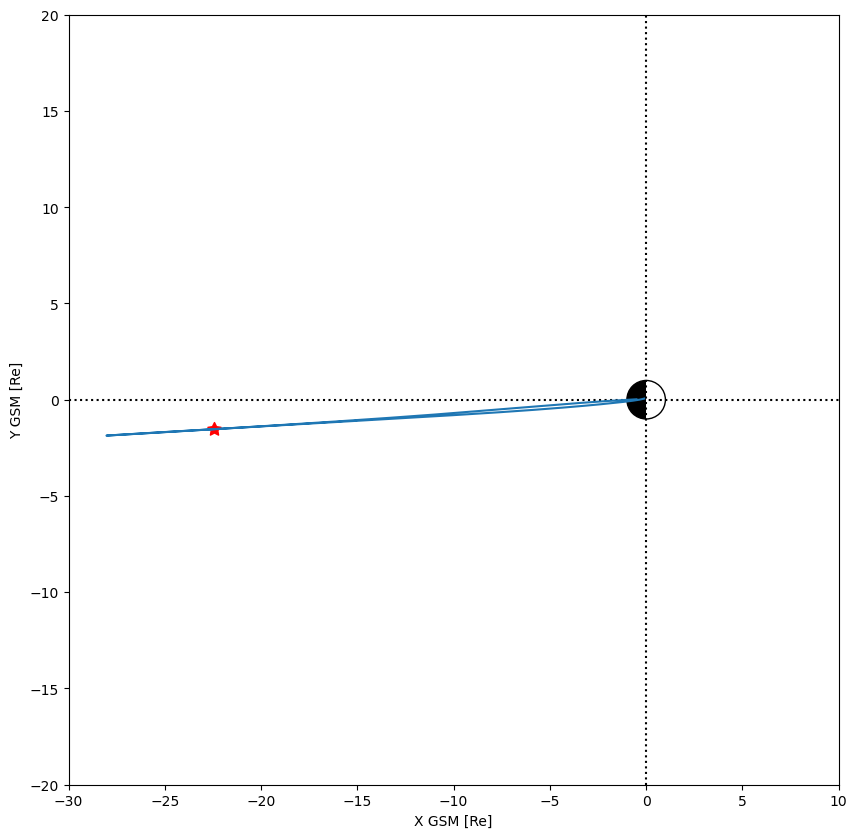

In [259]:
date = '2015-03-19 05:00:00'
ut = get_seconds(date)

vx = ace['Vx'][date]
vy = ace['Vy'][date]
vz = ace['Vz'][date]

ps = geopack.recalc(ut, vxgse=vx, vygse=vy, vzgse=vz)

# get station coordinates at datetime
ott_lat = df['GEOLAT'][date]
ott_lon = df['GEOLON'][date]
# ott_lon = ott_lon + 360 if ott_lon < 0 else ott_lon
print(ott_lat, ott_lon)
ott_lat, ott_lon = 60.4, 284.45

# convert degrees to radians
lat_rad = np.deg2rad(ott_lat)
lon_rad = np.deg2rad(ott_lon)
print(lat_rad, lon_rad)

# Convert Geodetic to geocentric spherical
r, theta_rad = geopack.geodgeo(0, lat_rad, 1)
print(r, theta_rad, lon_rad)

# Converting Geocentric Spherical to Geocentric Cartesian
x_gc, y_gc, z_gc = geopack.sphcar(1, theta_rad, lon_rad, 1)
print('GC:  ', x_gc,y_gc,z_gc,' R=',np.sqrt(x_gc**2+y_gc**2+z_gc**2))

# Convert Geocentric Cartesian to GSM
x_gsm, y_gsm, z_gsm = geopack.geogsm(x_gc, y_gc, z_gc, 1)
print('GSM: ', x_gsm,y_gsm,z_gsm,' R=',np.sqrt(x_gsm**2+y_gsm**2+z_gsm**2))

x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
# print(x,y,z)
closest_to_zero = min(zz, key=abs)
print(closest_to_zero)
print(np.argmin(np.abs(zz)))
print(zz[np.argmin(np.abs(zz))])
print(xx[np.argmin(np.abs(zz))])
print(yy[np.argmin(np.abs(zz))])
xf, yf, zmin = get_footpoint(x_gsm, y_gsm, z_gsm, vx, vy, vz, date)
print(f'Footprints: {xf}, {yf}, {zmin}')

ax=setup_fig(plotting_y=True)
ax.plot(xx, yy)
ax.scatter(xx[np.argmin(np.abs(zz))], yy[np.argmin(np.abs(zz))], color='r', s=100, marker=(5,1))
plt.show()

In [239]:
# Return index where field line goes closest to z=0 and its value
def find_nearest_z(z_arr, value):
    array = np.asarray(z_arr)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

# Takes: dt, th_loc[x,y,z] (assumes get_th_xyz() has already been called)
# Returns: x,y coordinates of the traced equatorial "footpoint"
def get_footpoint(x_gsm, y_gsm, z_gsm, vx, vy, vz, dt):
    # Calculate dipole tilt angle
    ut = get_seconds(dt)
    ps = geopack.recalc(ut, vxgse=vx, vygse=vy, vzgse=vz)
    # Calculate field line (both directions)
    x,y,z,xx,yy,zz = geopack.trace(x_gsm,y_gsm,z_gsm,dir=1,rlim=21,r0=.99999,
                                   parmod=2,exname='t89',inname='igrf',maxloop=1000)
    # Check that field lines start and terminate at Earth
    if (abs(xx[0]) > 1):
        print(f'Field line failed to terminate at Earth. UT: {ut}')
    mindex, z_min = find_nearest_z(zz, 0)
    xf = xx[mindex]
    yf = yy[mindex]    
    return xf, yf, z_min

# should be ~(0.574, -1.721)

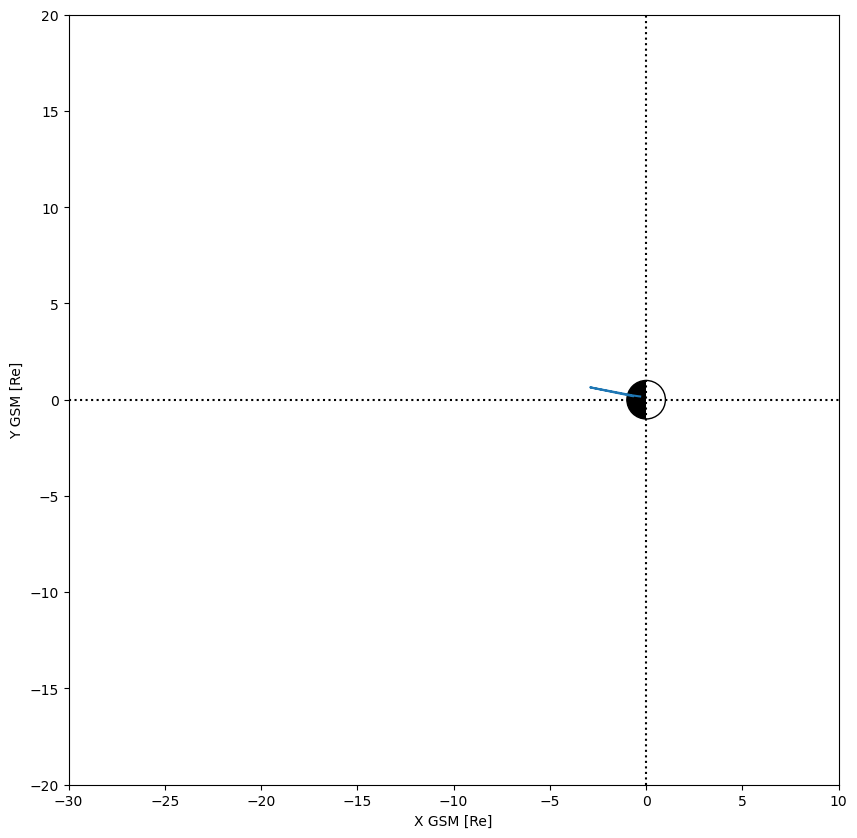

In [217]:
ax=setup_fig(plotting_y=True)
ax.plot(xx, yy)
plt.show()

In [101]:
ut = 100
xgsm,ygsm,zgsm = [1,2,3]
ps = geopack.recalc(ut)
b0xgsm,b0ygsm,b0zgsm = geopack.dip(x_gsm,y_gsm,z_gsm)    		# calc dipole B in GSM.
dbxgsm,dbygsm,dbzgsm = t89.t89(2, ps, x_gsm,y_gsm,z_gsm)       # calc T89 dB in GSM.
bxgsm,bygsm,bzgsm = [b0xgsm+dbxgsm,b0ygsm+dbygsm,b0zgsm+dbzgsm]
print(bxgsm,bygsm,bzgsm)
xx, yy, zz = [x_gsm+bxgsm, x_gsm], [y_gsm+bygsm, y_gsm], [z_gsm+bzgsm, z_gsm]

20728.593426175434 -18668.484872974885 -53816.536977917785


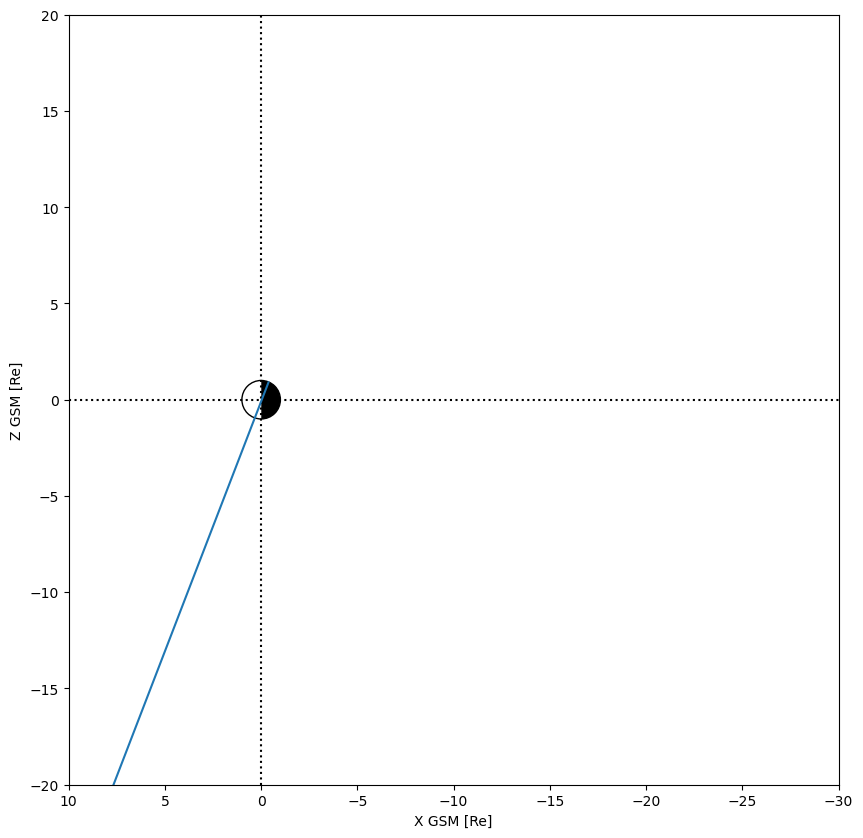

In [102]:
ax = setup_fig()
ax.plot(xx, zz)
plt.show()